# TODO convert precip to mm from volume

In [1]:
import os
from pathlib import Path
import geopandas as gpd
import xarray as xr
import pandas as pd
import numpy as np
from tqdm import tqdm

mwb_flow_dir = r'C:\Users\CND905\Downloaded_Programs\mwb_flow'
os.chdir(mwb_flow_dir)

from mwb_flow.model import WB_Model
 

Initializing mwb_flow module.


The model calls for:

dates as a vectors/1d array

temp and precip are ndarrays

and mon_Q is a pandas series with dates as index and flow in m^3/s


In [2]:
data_arr = xr.load_dataset(r'C:\Users\CND905\Downloaded_Programs\mwb_flow\Examples\dataprep_Example1.1_PullData_output.nc')
soil_stor_cap = 75
init_per = 1
temp_sno=0
temp_rain=5
dr_frac=0.06
mlt_rate=0.6
sr_factor=0.5

In [3]:
data_arr

<xarray.Dataset> Size: 7kB
Dimensions:       (location: 6, time: 48)
Coordinates:
  * location      (location) int64 48B 1000 2800 3000 5500 9500 9600
    lat           (location) float64 48B 46.7 46.82 46.78 46.67 46.75 46.75
    area          (location) float64 48B 185.3 34.26 186.8 139.0 102.1 57.96
  * time          (time) datetime64[ns] 384B 2016-01-01 ... 2019-12-01
Data variables:
    mo_temp       (time, location) float64 2kB -3.117 -2.703 ... -2.364 -2.272
    mo_precip     (time, location) float64 2kB 119.3 184.6 98.12 ... 213.1 210.3
    mo_discharge  (time, location) float64 2kB 12.89 nan nan ... 50.06 78.89
Attributes:
    standard_name:  Monthly_Temperature
    units:          Celcius

# def __init__(self, data_dict, soil_stor_cap, latitude, init_per, Temp_sno=0, Temp_rain=5, dr_frac=0.06, mlt_rate=0.6, rfactor=0.5):

In [4]:
# Arguments for model __init__()
soil_stor_cap = 75
init_per = 1
temp_sno=0
temp_rain=5
dr_frac=0.06
mlt_rate=0.6
sr_factor=0.5

#Method to initiate 
STC = np.repeat(soil_stor_cap, len(data_arr.coords["location"].values))
snotemp = np.repeat(temp_sno, len(data_arr.coords["location"].values))
raintemp = np.repeat(temp_rain, len(data_arr.coords["location"].values))
DRF = np.repeat(dr_frac, len(data_arr.coords["location"].values))
melt_coef = np.repeat(mlt_rate, len(data_arr.coords["location"].values))
SRF = np.repeat(sr_factor, len(data_arr.coords["location"].values))
latitude = data_arr.coords["lat"].values
init_per = init_per
STo = np.repeat(0, len(data_arr.coords["location"].values))
snw_st_init = np.repeat(0, len(data_arr.coords["location"].values))
Sur_init = np.repeat(0, len(data_arr.coords["location"].values))

# Calibration Parameter Ranges
snotemp_rng = [-10, 0]
raintemp_rng = [0, 10]
DRF_rng = [0.01, 0.99]
melt_coef_rng = [0.01, 0.99]
SRF_rng = [0.01, 0.99]
# TODO edit code to accept xarray.datasets instead of a dictionary
# Updated latitude, T, P, dates, monthly_Q, days_in_mnth
# data_dict inputs are indexed to the first columns of arrays
T = data_arr.mo_temp.values
P = data_arr.mo_precip.values
val_Q = data_arr.mo_discharge.values
times = pd.to_datetime(data_arr.coords["time"].values)
days_in_mnth = pd.to_datetime(data_arr.coords["time"].values).daysinmonth.to_numpy()

# metadata
locations = data_arr['location'].values

# gridded data for WB variables
snowfall = None
snow_stor = None
P_snow_melt = None
snowmelt = None
soil_m = None
PET = None
AET = None
rain = None
direct_runoff = None
surplus_runoff = None
runoff = None

# def _day_length(self):

In [5]:
rad_lat = np.tile(np.radians(latitude), (len(times), 1)) # Calc radians and convert to 2D array
days = times + pd.Timedelta(15, unit='D')
J = np.transpose(np.tile(days.dayofyear.values, (len(latitude), 1))) # Calc dayofyear and convert to 2D array
decimal = 0.409 * np.sin((2 * np.pi / 365) * J - 1.39)
sunset_ang = np.arccos(-np.tan(rad_lat)*np.tan(decimal))
day_len = (24/np.pi)*sunset_ang
day_len


array([[ 8.78855117,  8.77341247,  8.77892794,  8.79229465,  8.78213869,
         8.78224193],
       [10.13070857, 10.12225519, 10.12533441, 10.1327997 , 10.12712724,
        10.12718489],
       [11.7292079 , 11.72800751, 11.72844472, 11.72950489, 11.72869931,
        11.72870749],
       [13.47251363, 13.47912093, 13.47671424, 13.47087905, 13.47531294,
        13.47526788],
       [14.90992304, 14.9234838 , 14.91854349, 14.90656938, 14.91566742,
        14.91557494],
       [15.6404559 , 15.65794028, 15.6515696 , 15.63613317, 15.64786133,
        15.6477421 ],
       [15.22713439, 15.24235667, 15.23681073, 15.22337026, 15.23358225,
        15.23347844],
       [13.89511509, 13.90369017, 13.90056661, 13.89299385, 13.89874797,
        13.89868949],
       [12.18528198, 12.18610312, 12.18580404, 12.18507881, 12.18562989,
        12.18562429],
       [10.50051012, 10.49377862, 10.49623055, 10.50217542, 10.4976582 ,
        10.49770411],
       [ 9.03230656,  9.01844755,  9.02349657,  9.

# def _snow_input(self, Tsnow, Train)
Tsnow and Train are assigned from snotemp and raintemp in the run_model method. So we assign the Tsnow, and Train values now.

In [6]:
# Arguments to run method. These are assigned in the run_model() method.
Tsnow = snotemp
Train = raintemp

In [7]:

Tsnow_arr = np.tile(Tsnow, (len(times), 1))
Train_arr = np.tile(Train, (len(times), 1))

sno_ind = np.where(T <= Tsnow_arr)
mix_ind = np.where((T > Tsnow_arr) & (T < Train))
rain_ind = np.where(T >= Train_arr)
Psnow = P * 1.0 # Create 2D array and replace if T is greater than Tsnow
Psnow[sno_ind] = Psnow[sno_ind]
Psnow[mix_ind] = Psnow[mix_ind] * ((Train_arr[mix_ind] - T[mix_ind])/(Train_arr[mix_ind] - Tsnow_arr[mix_ind]))
Psnow[rain_ind] = 0.0
Psnow

array([[119.3455353 , 184.59720135,  98.12175165, 111.61018854,
        152.27301236, 148.63021009],
       [ 87.82622406, 119.15933369,  56.70701335,  82.01290713,
         87.01608378,  81.75197882],
       [110.86392871, 148.89371036,  62.38330975, 112.99851555,
        105.09498104,  94.89399338],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [ 64.48953069,  44.68496021,   0.69168784,  84.79561132,
          1.13524014,   0. 

# def _rain(self):

In [8]:
Prain = P - Psnow
Prain

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  6.81302155,  26.27924699,  17.45194333,   1.4453304 ,
         33.95546126,  34.35024379],
       [ 33.38947201,  79.41816208,  49.87099383,  17.45452305,
         82.21048283,  86.91773683],
       [ 36.25049138,  43.95722595,  31.78970888,  33.41223479,
         41.38451784,  39.02883899],
       [125.00904306, 149.36390159, 109.39459231, 117.89805702,
        147.23354913, 138.68384638],
       [ 56.67856819,  61.1393873 ,  46.18624615,  51.74221555,
         66.47796325,  61.68564098],
       [ 29.93663646,  34.12070764,  27.06835312,  26.67364808,
         33.41465677,  31.61076836],
       [ 14.3587885 ,  17.53555949,  14.49355228,  14.69665846,
         15.93423891,  15.25906078],
       [ 70.29091085,  85.14282051,  58.02108855,  64.13355572,
         83.4617455 ,  80.42941738],
       [261.02751425, 423.29942039, 269.93957453, 220.50798344,
        395.39934374, 392.9

# def _direct_runoff(self, drf):

drf assigned from DRF here since it is not assinged until the run_model method

In [9]:
# Argument to run method. This is assigned in the run_model() method.
drf = DRF

In [10]:
Dir_RO = drf * Prain
Dir_RO

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.40878129,  1.57675482,  1.0471166 ,  0.08671982,  2.03732768,
         2.06101463],
       [ 2.00336832,  4.76508972,  2.99225963,  1.04727138,  4.93262897,
         5.21506421],
       [ 2.17502948,  2.63743356,  1.90738253,  2.00473409,  2.48307107,
         2.34173034],
       [ 7.50054258,  8.9618341 ,  6.56367554,  7.07388342,  8.83401295,
         8.32103078],
       [ 3.40071409,  3.66836324,  2.77117477,  3.10453293,  3.98867779,
         3.70113846],
       [ 1.79619819,  2.04724246,  1.62410119,  1.60041888,  2.00487941,
         1.8966461 ],
       [ 0.86152731,  1.05213357,  0.86961314,  0.88179951,  0.95605433,
         0.91554365],
       [ 4.21745465,  5.10856923,  3.48126531,  3.84801334,  5.00770473,
         4.82576504],
       [15.66165085, 25.39796522, 16.19637447, 13.23047901, 23.72396062,
        23.57440463],
       [ 2.56561809,  5.25272229,  2.73817677,  2.

# def _snowmelt(self, alpha, Tsnow):

In [11]:
# Argument to run method. This is assigned in the run_model() method.
alpha = melt_coef

In [12]:
Sno_M = alpha * (T - Tsnow) * np.transpose(np.tile(days_in_mnth, (len(latitude), 1))) # Makes 2D array of days_in_mnth
Sno_M[Sno_M < 0.0] = 0.0
Sno_M

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  6.26307692,  15.72      ,  20.47384615,   1.50666667,
         24.42      ,  25.74      ],
       [ 21.52615385,  32.35      ,  41.31692308,  12.44333333,
         40.81875   ,  44.46      ],
       [122.52692308, 136.19      , 142.94538462, 111.68666667,
        140.22375   , 141.08      ],
       [157.71461538, 170.24      , 182.32846154, 144.41      ,
        174.1725    , 177.07      ],
       [239.53384615, 255.81      , 264.56769231, 233.58      ,
        266.19375   , 267.84      ],
       [269.97692308, 288.13      , 295.90615385, 267.86666667,
        303.32625   , 305.83      ],
       [273.39692308, 293.33      , 297.70153846, 272.78333333,
        304.36125   , 305.31      ],
       [165.83538462, 178.87      , 187.79769231, 162.20666667,
        188.4975    , 192.02      ],
       [ 74.57538462,  84.12      ,  92.76230769,  67.17      ,
         92.73375   ,  96.9

# def _PET(self):

In [13]:
e_sat = 6.108 * np.exp((17.27 * T) / (T + 237.3))
rho_sat = 216.7 * (e_sat / (T + 273.3))
# D = self._day_length()
D = day_len
Kpec = 1.0
# PET = 0.1651 * self.days_in_mnth[:,None, None] * (D[:,None,None]/12) * rho_sat * Kpec
PET = 0.1651 * (D/12) * rho_sat * Kpec * np.transpose(np.tile(days_in_mnth, (len(latitude), 1))) # Makes 2D array of days_in_mnth
PET

array([[ 14.59215105,  15.00053957,  14.97560696,  14.36480343,
         15.16089752,  14.81909947],
       [ 20.0682659 ,  20.81482842,  21.21448408,  19.69744245,
         21.54971153,  21.66171804],
       [ 26.23498642,  27.29523816,  28.2051689 ,  25.37166895,
         28.15459924,  28.5305953 ],
       [ 42.53225381,  44.70516993,  45.79556984,  40.88538099,
         45.34554236,  45.48506687],
       [ 54.20105953,  56.64383519,  59.02077779,  51.74604445,
         57.38391331,  57.95651331],
       [ 74.58929516,  78.94537529,  81.29771362,  73.05868617,
         81.72787206,  82.18443696],
       [ 80.81909559,  85.85499388,  88.02460127,  80.24019292,
         90.15092442,  90.88421092],
       [ 74.58263426,  79.65282674,  80.77483778,  74.42116521,
         82.52772819,  82.78129429],
       [ 44.93180363,  47.05634871,  48.55795091,  44.35549201,
         48.67679238,  49.2823425 ],
       [ 28.48068358,  29.45236976,  30.3815852 ,  27.73664864,
         30.3826284 ,  30.8

# def _soilmoisture_storage - Model Run
## def _soilmoisture_storage(self, dates, time_offset, Tsnow, Train, drf, alpha, rfactor):
This method is run as a warm up first to get the initial storage values needed to run the model. 

In [14]:

# Argument to run method as  warmup. These assigned in the run_model() method as kwargs.
rfactor = SRF
init_per = 12
time_offset = 0
dates = times[0:init_per]

In [15]:
# self.snowfall = self._snow_input(Tsnow, Train) 
snowfall = Psnow

# self.rain = self._rain()
rain = Prain


# self.direct_runoff = self._direct_runoff(drf)
direct_runoff = Dir_RO


# self.P_snow_melt = self._snowmelt(alpha, Tsnow)
P_snow_melt = Sno_M


# self.PET = self._PET()
PET = PET

STC = np.repeat(soil_stor_cap, len(data_arr.coords["location"].values))

STo = np.repeat(0, len(data_arr.coords["location"].values))
snw_st_init = np.repeat(0, len(data_arr.coords["location"].values))
Sur_init = np.repeat(0, len(data_arr.coords["location"].values))



smstor = [] # soil moisture storage
snowstor = [] # snow storage
surstor = [] # surplus storage
snwmlt = [] #snowmelt
AET_l = [] # AET list
surplus_r = [] # surplus runoff

for i in tqdm(np.arange(time_offset, len(dates))):
    if i == time_offset:
        STi_1 = STo
        sno_stori_1 = snw_st_init
        Suri_1 = Sur_init # Added for surplus calculation

    else:
        STi_1 = smstor[i-1]
        sno_stori_1 = snowstor[i-1]
        Suri_1 = surstor[i-1]
    

    # Snow Storage and snow melt
    snow_storage = sno_stori_1 + snowfall[i,:] - P_snow_melt[i,:]
    hi_snwm = np.where(snow_storage > 0.0)
    lo_snwm = np.where(snow_storage <= 0.0)

    snwm = P_snow_melt[i,:] * 1.0
    snwm[hi_snwm] = P_snow_melt[i,:][hi_snwm]
    snwm[lo_snwm] = sno_stori_1[lo_snwm] + snowfall[i,:][lo_snwm] # Why does the snwm include the snowstorage and snowfall?
    snow_storage[snow_storage < 0.0] = 0.0

    # Ptotal calc
    P_tot = (rain[i,:] - direct_runoff[i,:]) + snwm # Premain is nested in this eq. Error in paper.
    hi_pet = np.where(P_tot >= PET[i,:])
    lo_pet = np.where(P_tot < PET[i,:])

    #AET and ST calc
    AET = PET[i,:] * 1.0
    STi = STi_1 * 1.0

    ## High AET
    AET[hi_pet] = AET[hi_pet]
    STi[hi_pet] = STi_1[hi_pet] + (P_tot[hi_pet] - AET[hi_pet])
    ## Low AET
    STi[lo_pet] = STi_1[lo_pet] - (abs(P_tot[lo_pet] - PET[i,:][lo_pet]) * (STi_1[lo_pet]/STC[lo_pet])) # STi_1 starts as 0 so will always be 0 if P_tot is < PET
    STi[STi < 0] = 0
    STW = STi_1[lo_pet] - STi[lo_pet]
    AET[lo_pet] = P_tot[lo_pet] + STW
    
    # Surplus Runoff
    Suri = np.repeat(0, len(data_arr.coords["location"].values))
    hi_s = np.where(STi > STC)
    Suri[hi_s] = STi[hi_s] - STC[hi_s]
    Sur_RO = (Suri + Suri_1) * rfactor # Calculate surplus runoff for month
    Suri = Suri + Suri_1 - Sur_RO # Calculate remaining runoff for month

    smstor.append(STi)
    surstor.append(Suri)
    snowstor.append(snow_storage)
    snwmlt.append(snwm)
    AET_l.append(AET)
    surplus_r.append(Sur_RO)

soil_storage = np.stack(smstor, axis=0)
surplus_storage = np.stack(surstor, axis=0)
snow_storage = np.stack(snowstor, axis=0)
snowmelt = np.stack(snwmlt, axis=0)
AET = np.stack(AET_l, axis=0)
surplus_runoff = np.stack(surplus_r, axis=0)

res = xr.Dataset(
    {
        "soil_storage": (['time', 'location'], soil_storage, {'standard_name': 'soil storage',
                                                                'units': 'mm'}),
        "surplus_storage": (['time', 'location'], surplus_storage, {'standard_name': 'surplus storage',
                                                                'units': 'mm'}),
        "snow_storage": (['time', 'location'], snow_storage, {'standard_name': 'snow_storage',
                                                        'units': 'mm'}),
        "snowmelt": (['time', 'location'], snowmelt, {'standard_name': 'snowmelt', 
                                                                    'units': 'mm'}),
        "AET": (['time', 'location'], AET, {'standard_name': 'AET',
                                                        'units': 'mm'}),
        "surplus_runoff": (['time', 'location'], surplus_runoff, {'standard_name': 'surplus_runoff',
                                                                    'units': 'mm'})
                                                                
    },
    coords={
    "location": (['location'], data_arr['location'].values, {'long_name': 'location_identifier',
                                                                    'cf_role': 'timeseries_id'}),
    # Keep the order of xds
    "time": data_arr['time'].values[time_offset:len(dates)]
},
    attrs={
        "featureType": 'timeSeries',
    }
)
    
res

100%|██████████| 12/12 [00:00<00:00, 12046.83it/s]


<xarray.Dataset> Size: 4kB
Dimensions:          (time: 12, location: 6)
Coordinates:
  * location         (location) int64 48B 1000 2800 3000 5500 9500 9600
  * time             (time) datetime64[ns] 96B 2016-01-01 ... 2016-12-01
Data variables:
    soil_storage     (time, location) float64 576B 0.0 0.0 0.0 ... 426.4 409.2
    surplus_storage  (time, location) float64 576B 0.0 0.0 0.0 ... 321.4 306.2
    snow_storage     (time, location) float64 576B 119.3 184.6 ... 152.8 152.8
    snowmelt         (time, location) float64 576B 0.0 0.0 0.0 ... 0.0 0.0 0.0
    AET              (time, location) float64 576B 0.0 0.0 0.0 ... 64.12 61.75
    surplus_runoff   (time, location) float64 576B 0.0 0.0 0.0 ... 321.4 306.2
Attributes:
    featureType:  timeSeries

# def _model_warmup(self, dates, time_offset, Tsnow, Train, drf, alpha, rfactor):

In [16]:
RES = res
RES['soil_storage'].values[-1,:], RES['snow_storage'].values[-1,:], RES['surplus_storage'].values[-1,:]

(array([324.14533345, 501.37357717, 258.68785849, 281.21653018,
        426.40592678, 409.17606623]),
 array([158.2837474 , 210.1547024 ,  98.32930664, 160.60375026,
        152.82730151, 152.76140655]),
 array([232.30664062, 394.55273438, 168.00195312, 192.91015625,
        321.44824219, 306.20703125]))

# def_run_model(self, Tsnow=None, Train=None, drf=None, alpha=None, rfactor=None):

In [17]:
Tsnow=None
Train=None
drf=None
alpha=None
rfactor=None

kwargs = dict(Tsnow=Tsnow,
            Train=Train,
            drf=drf,
            alpha=alpha,
            rfactor=rfactor)

selfkwargs = dict(Tsnow=snotemp,
                Train=raintemp,
                drf=DRF,
                alpha=melt_coef,
                rfactor=SRF)

for key in kwargs:
    if kwargs[key] == None:
        kwargs[key] = selfkwargs[key]


warmup_dates = times[0:init_per]


w_args = [warmup_dates, 0, kwargs['Tsnow'], kwargs['Train'], kwargs['drf'], kwargs['alpha'], kwargs['rfactor']]
args = [times, init_per, kwargs['Tsnow'], kwargs['Train'], kwargs['drf'], kwargs['alpha'], kwargs['rfactor']]

# w_args and args are used to run the warmup and actual model respectivly. 

# def _soilmoisture_storage - Model Run
## def _soilmoisture_storage(self, dates, time_offset, Tsnow, Train, drf, alpha, rfactor):
This method is run again as the model while using the storage values from the previous warmup run.

In [18]:
# Argument to run method at the model. These values are assigned in the run_model() method as kwargs.
rfactor = SRF
time_offset = init_per
dates = times



# self.snowfall = self._snow_input(Tsnow, Train) 
snowfall = Psnow

# self.rain = self._rain()
rain = Prain


# self.direct_runoff = self._direct_runoff(drf)
direct_runoff = Dir_RO


# self.P_snow_melt = self._snowmelt(alpha, Tsnow)
P_snow_melt = Sno_M


# self.PET = self._PET()
PET = PET

STC = np.repeat(soil_stor_cap, len(data_arr.coords["location"].values))

STo = np.repeat(0, len(data_arr.coords["location"].values))
snw_st_init = np.repeat(0, len(data_arr.coords["location"].values))
Sur_init = np.repeat(0, len(data_arr.coords["location"].values))



smstor = [] # soil moisture storage
snowstor = [] # snow storage
surstor = [] # surplus storage
snwmlt = [] #snowmelt
AET_l = [] # AET list
surplus_r = [] # surplus runoff

for i in tqdm(np.arange(time_offset, len(dates))):
    if i == time_offset:
        STi_1 = RES['soil_storage'].values[-1,:]
        sno_stori_1 = RES['snow_storage'].values[-1,:]
        Suri_1 = RES['surplus_storage'].values[-1,:]

    else:
        if time_offset == 0:
            STi_1 = smstor[i-1]
            sno_stori_1 = snowstor[i-1]
            Suri_1 = surstor[i-1]
        elif time_offset == init_per:
            STi_1 = smstor[i-(init_per + 1)]
            sno_stori_1 = snowstor[i-(init_per + 1)]
            Suri_1 = surstor[i-(init_per + 1)]
        else:
            print(f"Error in warmup argument. Evaluate row {i}")

    

    # Snow Storage and snow melt
    snow_storage = sno_stori_1 + snowfall[i,:] - P_snow_melt[i,:]
    hi_snwm = np.where(snow_storage > 0.0)
    lo_snwm = np.where(snow_storage <= 0.0)

    snwm = P_snow_melt[i,:] * 1.0
    snwm[hi_snwm] = P_snow_melt[i,:][hi_snwm]
    snwm[lo_snwm] = sno_stori_1[lo_snwm] + snowfall[i,:][lo_snwm] # Why does the snwm include the snowstorage and snowfall?
    snow_storage[snow_storage < 0.0] = 0.0

    # Ptotal calc
    P_tot = (rain[i,:] - direct_runoff[i,:]) + snwm # Premain is nested in this eq. Error in paper.
    hi_pet = np.where(P_tot >= PET[i,:])
    lo_pet = np.where(P_tot < PET[i,:])

    #AET and ST calc
    AET = PET[i,:] * 1.0
    STi = STi_1 * 1.0

    ## High AET
    AET[hi_pet] = AET[hi_pet]
    STi[hi_pet] = STi_1[hi_pet] + (P_tot[hi_pet] - AET[hi_pet])
    ## Low AET
    STi[lo_pet] = STi_1[lo_pet] - (abs(P_tot[lo_pet] - PET[i,:][lo_pet]) * (STi_1[lo_pet]/STC[lo_pet])) # STi_1 starts as 0 so will always be 0 if P_tot is < PET
    STi[STi < 0] = 0
    STW = STi_1[lo_pet] - STi[lo_pet]
    AET[lo_pet] = P_tot[lo_pet] + STW
    
    # Surplus Runoff
    Suri = np.repeat(0, len(data_arr.coords["location"].values))
    hi_s = np.where(STi > STC)
    Suri[hi_s] = STi[hi_s] - STC[hi_s]
    Sur_RO = (Suri + Suri_1) * rfactor # Calculate surplus runoff for month
    Suri = Suri + Suri_1 - Sur_RO # Calculate remaining runoff for month

    smstor.append(STi)
    surstor.append(Suri)
    snowstor.append(snow_storage)
    snwmlt.append(snwm)
    AET_l.append(AET)
    surplus_r.append(Sur_RO)

soil_storage = np.stack(smstor, axis=0)
surplus_storage = np.stack(surstor, axis=0)
snow_storage = np.stack(snowstor, axis=0)
snowmelt = np.stack(snwmlt, axis=0)
AET = np.stack(AET_l, axis=0)
surplus_runoff = np.stack(surplus_r, axis=0)

res = xr.Dataset(
    {
        "soil_storage": (['time', 'location'], soil_storage, {'standard_name': 'soil storage',
                                                                'units': 'mm'}),
        "surplus_storage": (['time', 'location'], surplus_storage, {'standard_name': 'surplus storage',
                                                                'units': 'mm'}),
        "snow_storage": (['time', 'location'], snow_storage, {'standard_name': 'snow_storage',
                                                        'units': 'mm'}),
        "snowmelt": (['time', 'location'], snowmelt, {'standard_name': 'snowmelt', 
                                                                    'units': 'mm'}),
        "AET": (['time', 'location'], AET, {'standard_name': 'AET',
                                                        'units': 'mm'}),
        "surplus_runoff": (['time', 'location'], surplus_runoff, {'standard_name': 'surplus_runoff',
                                                                    'units': 'mm'})
                                                                
    },
    coords={
    "location": (['location'], data_arr['location'].values, {'long_name': 'location_identifier',
                                                                    'cf_role': 'timeseries_id'}),
    # Keep the order of xds
    "time": data_arr['time'].values[time_offset:len(dates)]
},
    attrs={
        "featureType": 'timeSeries',
    }
)
    
result = res
result

100%|██████████| 36/36 [00:00<00:00, 11545.72it/s]


<xarray.Dataset> Size: 11kB
Dimensions:          (time: 36, location: 6)
Coordinates:
  * location         (location) int64 48B 1000 2800 3000 5500 9500 9600
  * time             (time) datetime64[ns] 288B 2017-01-01 ... 2019-12-01
Data variables:
    soil_storage     (time, location) float64 2kB 278.0 427.4 ... 144.1 120.8
    surplus_storage  (time, location) float64 2kB 217.2 373.3 ... 110.9 79.7
    snow_storage     (time, location) float64 2kB 216.8 298.4 ... 345.9 330.1
    snowmelt         (time, location) float64 2kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    AET              (time, location) float64 2kB 46.18 73.94 ... 34.92 29.52
    surplus_runoff   (time, location) float64 2kB 217.2 373.3 ... 110.9 79.7
Attributes:
    featureType:  timeSeries

In [19]:
# These lines of code follow the re-run of the  _soilmoisture_storage method inside the run_model() function. This organizes the results into a dataarray.
p = P[init_per:len(times)]
p_arr = xr.DataArray(p, coords=result.coords, attrs={'standard_name': 'Precipitation', 'units': 'mm'})
p_arr.name = 'precipitation'

Tot_RO = result['surplus_runoff'].values + direct_runoff[init_per:len(times)]
Tot_RO_arr = xr.DataArray(Tot_RO, coords=result.coords, attrs={'standard_name': 'Total Runoff', 'units': 'mm'})
Tot_RO_arr.name = 'total_runoff'
result_xds = xr.merge([result, Tot_RO_arr, p_arr])
result_xds


<xarray.Dataset> Size: 14kB
Dimensions:          (time: 36, location: 6)
Coordinates:
  * location         (location) int64 48B 1000 2800 3000 5500 9500 9600
  * time             (time) datetime64[ns] 288B 2017-01-01 ... 2019-12-01
Data variables:
    soil_storage     (time, location) float64 2kB 278.0 427.4 ... 144.1 120.8
    surplus_storage  (time, location) float64 2kB 217.2 373.3 ... 110.9 79.7
    snow_storage     (time, location) float64 2kB 216.8 298.4 ... 345.9 330.1
    snowmelt         (time, location) float64 2kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    AET              (time, location) float64 2kB 46.18 73.94 ... 34.92 29.52
    surplus_runoff   (time, location) float64 2kB 217.2 373.3 ... 110.9 79.7
    total_runoff     (time, location) float64 2kB 217.2 373.3 ... 110.9 79.7
    precipitation    (time, location) float64 2kB 58.5 88.23 ... 213.1 210.3
Attributes:
    featureType:  timeSeries

Use the class object to run model

In [20]:
import matplotlib.pyplot as plt

Initializing Model


100%|██████████| 12/12 [00:00<?, ?it/s]


Running Model


100%|██████████| 36/36 [00:00<00:00, 18074.57it/s]


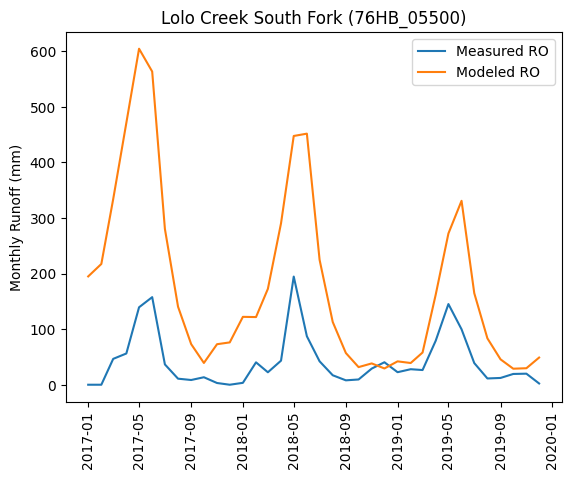

In [34]:
model = WB_Model(data_arr = data_arr, init_per=12, soil_stor_cap=60, temp_sno=-5,
                 temp_rain=5, dr_frac=0.06, mlt_rate=0.6, sr_factor=0.5)
results = model.run_model()

watershed_index = 3 #S.Fork has no upstream water inputs
x = results['time'].values
y1 = model.val_Q[12:,watershed_index]
y2 = results['total_runoff'].values[:,watershed_index]

plt.xticks(rotation=90)
plt.plot(x, y1)
plt.plot(x, y2)
plt.title("Lolo Creek South Fork (76HB_05500)")
plt.ylabel("Monthly Runoff (mm)")
classes = ['Measured RO', 'Modeled RO']
plt.legend(labels=classes)

plt.show()

